In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import re, os, sys, json, cv2, random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import numpy as np
import torchvision
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    f1_score,
    classification_report,
    confusion_matrix,
)
import seaborn as sns

Mountain               : 100%|████████████████████████████████████████| 2000/2000 [00:00<00:00, 2589.99file/s]


5 kind of images were found in the dataset
10000 images were found in the dataset.
8000 for training, 2000 for validation
average image height=  193   average image width=  266  aspect ratio h/w=  0.7255639097744361


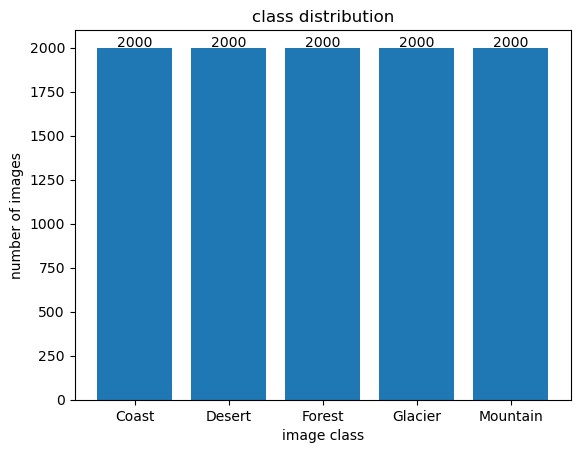

In [3]:
root = "../../Dataset/Landscape Classification/train"


def read_split_data(root, plot_image=False):
    filepaths = []
    labels = []
    bad_images = []

    random.seed(0)
    # assert os.path.exists(root), "wdnmd, 你tm路径不对啊!"

    classes = [
        cla for cla in os.listdir(root) if os.path.isdir(os.path.join(root, cla))
    ]
    classes.sort()
    class_indices = {k: v for v, k in enumerate(classes)}

    json_str = json.dumps({v: k for k, v in class_indices.items()}, indent=4)

    with open("classes_indices.json", "w") as json_file:
        json_file.write(json_str)

    every_class_num = []
    supported = [".jpg", ".png", ".jpeg", ".PNG", ".JPG", ".JPEG"]

    for klass in classes:
        classpath = os.path.join(root, klass)
        images = [
            os.path.join(root, klass, i)
            for i in os.listdir(classpath)
            if os.path.splitext(i)[-1] in supported
        ]
        every_class_num.append(len(images))
        flist = sorted(os.listdir(classpath))
        desc = f"{klass:23s}"
        for f in tqdm(flist, ncols=110, desc=desc, unit="file", colour="blue"):
            fpath = os.path.join(classpath, f)
            fl = f.lower()
            index = fl.rfind(".")
            ext = fl[index:]
            if ext in supported:
                try:
                    img = cv2.imread(fpath)
                    filepaths.append(fpath)
                    labels.append(klass)
                except:
                    bad_images.append(fpath)
                    print("defective image file: ", fpath)
            else:
                bad_images.append(fpath)

    Fseries = pd.Series(filepaths, name="filepaths")
    Lseries = pd.Series(labels, name="labels")
    df = pd.concat([Fseries, Lseries], axis=1)

    print(f"{len(df.labels.unique())} kind of images were found in the dataset")
    train_df, test_df = train_test_split(
        df, train_size=0.8, shuffle=True, random_state=123, stratify=df["labels"]
    )

    train_image_path = train_df["filepaths"].tolist()
    val_image_path = test_df["filepaths"].tolist()

    train_image_label = [class_indices[i] for i in train_df["labels"].tolist()]
    val_image_label = [class_indices[i] for i in test_df["labels"].tolist()]

    sample_df = train_df.sample(n=50, replace=False)
    ht, wt, count = 0, 0, 0
    for i in range(len(sample_df)):
        fpath = sample_df["filepaths"].iloc[i]
        try:
            img = cv2.imread(fpath)
            h = img.shape[0]
            w = img.shape[1]
            ht += h
            wt += w
            count += 1
        except:
            pass

    have = int(ht / count)
    wave = int(wt / count)
    aspect_ratio = have / wave
    print(
        "{} images were found in the dataset.\n{} for training, {} for validation".format(
            sum(every_class_num), len(train_image_path), len(val_image_path)
        )
    )
    print(
        "average image height= ",
        have,
        "  average image width= ",
        wave,
        " aspect ratio h/w= ",
        aspect_ratio,
    )

    if plot_image:
        plt.bar(range(len(classes)), every_class_num, align="center")
        plt.xticks(range(len(classes)), classes)

        for i, v in enumerate(every_class_num):
            plt.text(x=i, y=v + 5, s=str(v), ha="center")

        plt.xlabel("image class")
        plt.ylabel("number of images")

        plt.title("class distribution")
        plt.show()

    return (
        train_image_path,
        train_image_label,
        val_image_path,
        val_image_label,
        class_indices,
    )


train_image_path, train_image_label, val_image_path, val_image_label, class_indices = (
    read_split_data(root, plot_image=True)
)

In [4]:
class MyDataset(Dataset):
    def __init__(self, image_path, image_labels, transforms=None):
        self.image_path = image_path
        self.image_labels = image_labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        image = Image.open(self.image_path[idx]).convert("RGB")
        label = self.image_labels[idx]
        if self.transforms:
            image = self.transforms(image)
        return image, label

    @staticmethod
    def collate_fn(batch):
        images, labels = tuple(zip(*batch))
        images = torch.stack(images, dim=0)
        labels = torch.as_tensor(labels)
        return images, labels

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 32
epochs = 5
weight_decay = 1e-5
lr = 0.001

data_transform = {
    "train": transforms.Compose(
        [
            transforms.RandomResizedCrop(224),
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "valid": transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

train_dataset = MyDataset(train_image_path, train_image_label, data_transform["train"])
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=train_dataset.collate_fn,
)

valid_dataset = MyDataset(val_image_path, val_image_label, data_transform["valid"])
valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    collate_fn=valid_dataset.collate_fn,
)

In [6]:
net = torchvision.models.efficientnet_b3(pretrained=True)
# finetune_net.classifier
net.classifier = nn.Sequential(
    nn.Dropout(0.4, inplace=True),
    nn.Linear(1536, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024, 5),
)
net = net.to(device)

/home/mohanakrishna/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mohanakrishna/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
def train_step(net, optimizer, data_loader, device, epoch):
    net.train()
    loss_function = nn.CrossEntropyLoss()
    train_acc, train_loss, sampleNum = 0, 0, 0

    optimizer.zero_grad()

    train_bar = tqdm(data_loader, file=sys.stdout, colour="red")
    for step, data in enumerate(train_bar):
        images, labels = data
        sampleNum += images.shape[0]
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(images)
        loss = loss_function(outputs, labels)
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, dim=1) == labels).sum().item()
        loss.backward()
        optimizer.step()
        train_bar.desc = "[train epoch {}] loss: {:.3f}, acc: {:.3f}".format(
            epoch, train_loss / (step + 1), train_acc / sampleNum
        )

    return train_loss / (step + 1), train_acc / sampleNum


@torch.no_grad()
def val_step(net, data_loader, device, epoch):
    loss_function = nn.CrossEntropyLoss()
    net.eval()
    val_acc = 0
    val_loss = 0
    sample_num = 0
    val_bar = tqdm(data_loader, file=sys.stdout, colour="red")
    for step, data in enumerate(val_bar):
        images, labels = data
        sample_num += images.shape[0]
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        loss = loss_function(outputs, labels)
        val_loss += loss.item()
        val_acc += (torch.argmax(outputs, dim=1) == labels).sum().item()
        val_bar.desc = "[valid epoch {}] loss: {:.3f}, acc: {:.3f}".format(
            epoch, val_loss / (step + 1), val_acc / sample_num
        )

    return val_loss / (step + 1), val_acc / sample_num

In [8]:
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

best_val_acc = 0

for epoch in range(15):
    train_loss, train_accuracy = train_step(net, optimizer, train_loader, device, epoch)
    val_loss, val_accuracy = val_step(net, valid_loader, device, epoch)

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(net.state_dict(), f"./model_{epoch}.pth")

[valid epoch 14] loss: 0.359, acc: 0.888: 100%|██████████| 63/63 [00:05<00:00, 10.70it/s]


there were 214 errors in 2000 tests for an accuracy of  89.30%
The F1-score was 89.152


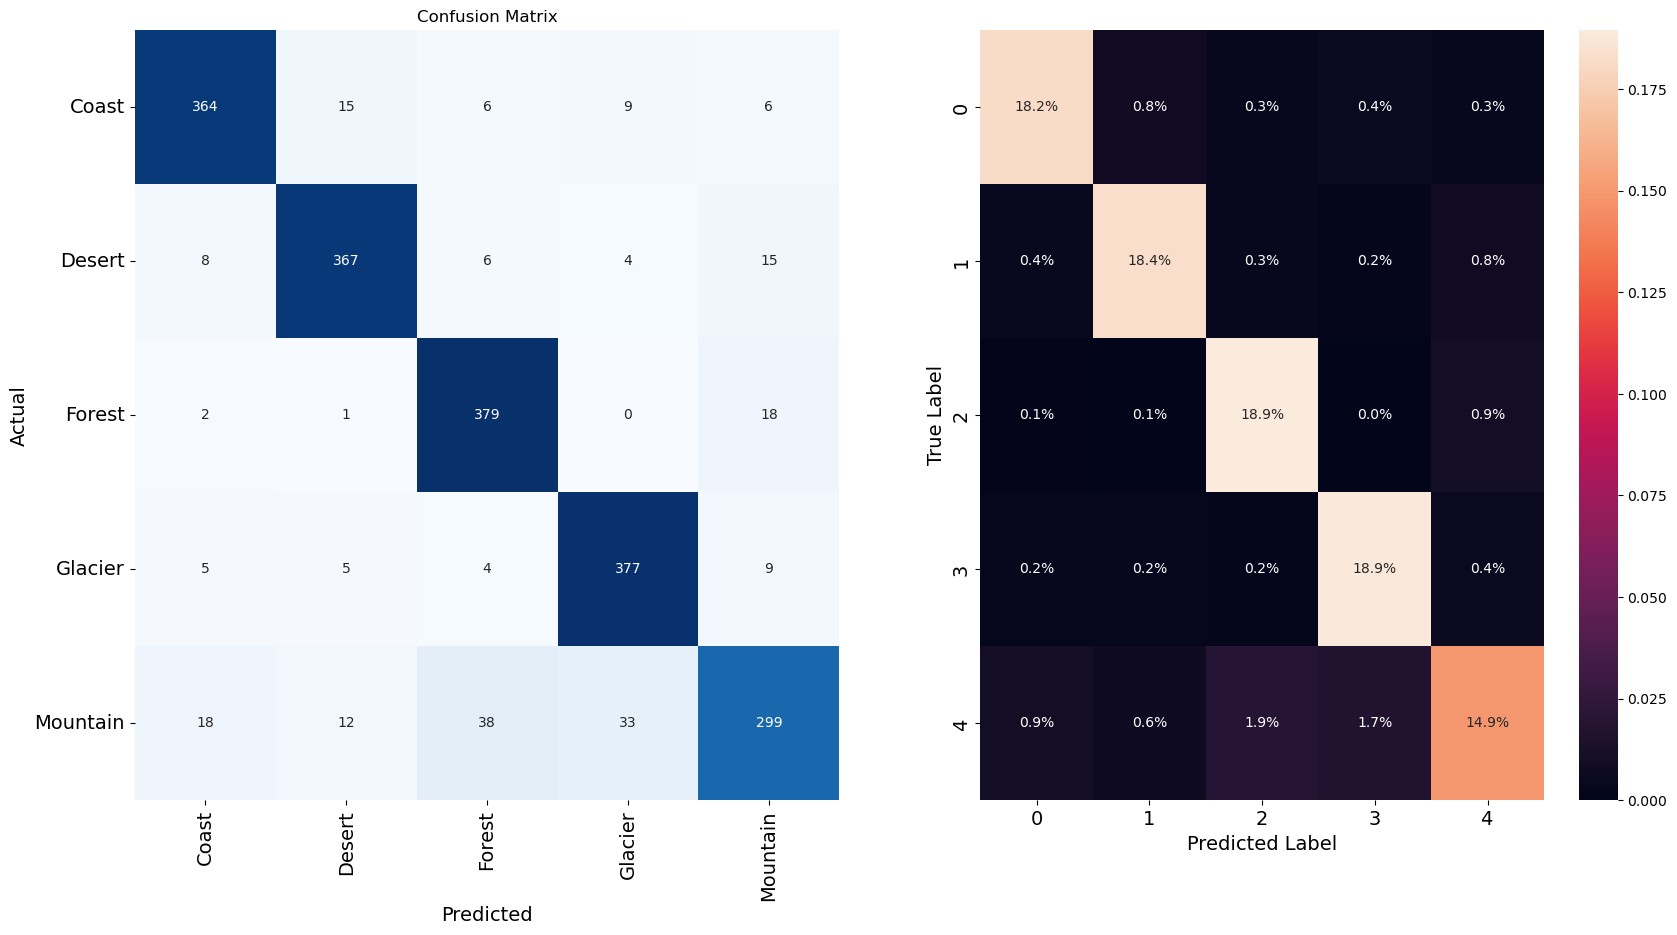

Classification Report:
----------------------
               precision    recall  f1-score   support

       Coast     0.9169    0.9100    0.9134       400
      Desert     0.9175    0.9175    0.9175       400
      Forest     0.8753    0.9475    0.9100       400
     Glacier     0.8913    0.9425    0.9162       400
    Mountain     0.8617    0.7475    0.8005       400

    accuracy                         0.8930      2000
   macro avg     0.8925    0.8930    0.8915      2000
weighted avg     0.8925    0.8930    0.8915      2000



In [10]:
try:
    json_file = open("./classes_indices.json", "r")
    class_indict = json.load(json_file)
except Exception as e:
    print(e)
    exit(-1)


def predictor(testloader):
    errors = 0
    y_pred, y_true = [], []

    save_path = "./model_13.pth"
    assert os.path.exists(save_path)
    net.load_state_dict(torch.load(save_path))

    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            preds = torch.argmax(net(images), dim=1)
            for i in range(len(preds)):
                y_pred.append(preds[i].cpu())
                y_true.append(labels[i].cpu())

    tests = len(y_pred)
    for i in range(tests):
        pred_index = y_pred[i]
        true_index = y_true[i]
        if pred_index != true_index:
            errors += 1
    acc = (1 - errors / tests) * 100
    print(f"there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}%")

    ypred = np.array(y_pred)
    ytrue = np.array(y_true)

    f1score = f1_score(ytrue, ypred, average="weighted") * 100
    print(f"The F1-score was {f1score:.3f}")

    class_count = len(list(class_indict.values()))
    classes = list(class_indict.values())

    cm = confusion_matrix(ytrue, y_pred)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, vmin=0, fmt="g", cmap="Blues", cbar=False)
    plt.xticks(np.arange(class_count) + 0.5, classes, rotation=90, fontsize=14)
    plt.yticks(np.arange(class_count) + 0.5, classes, rotation=0, fontsize=14)
    plt.xlabel("Predicted", fontsize=14)
    plt.ylabel("Actual", fontsize=14)
    plt.title("Confusion Matrix")

    plt.subplot(1, 2, 2)
    sns.heatmap(cm / np.sum(cm), annot=True, fmt=".1%")
    plt.xlabel("Predicted Label", fontsize=14)
    plt.xticks(fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)
    print("Classification Report:\n----------------------\n", clr)

    return f1score


f1score = predictor(valid_loader)